# **Sentiment Analysis**

**Objective:**
Create a basic sentiment analysis model that can classify text as positive, negative, or neutral using Python. This task will involve data preprocessing, model training, and evaluation.

Dataset used: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

## Imports

In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix

# import tensorflow_hub as hub
# import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Embedding, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

import tkinter as tk
from tkinter import ttk
import joblib
import json

## Data Preprocessing

In [ ]:
# # Data Acquiring from kaggle:

# !pip install kaggle

# # Download Dataset using Kaggle API
# ! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -p /content/drive/My\ Drive/Datasets

# # Extract the dataset
# import zipfile

# with zipfile.ZipFile('/content/drive/My Drive/Datasets/imdb-dataset-of-50k-movie-reviews.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/My Drive/Datasets/')

# print(f'DataFrame has been saved.')


# # Loading the dataset into a Pandas DataFrame
# csv_file='/content/drive/My Drive/Datasets/IMDB Dataset.csv'
# df = pd.read_csv(csv_file)
# df.head()

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 97% 25.0M/25.7M [00:01<00:00, 35.9MB/s]
100% 25.7M/25.7M [00:01<00:00, 22.3MB/s]
DataFrame has been saved.


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# # Loading the dataset into a Pandas DataFrame
# csv_file='C:\\Users\\pc\\Documents\\IMDB Dataset.csv'
# df = pd.read_csv(csv_file)
# df.head()

In [48]:
df = pd.read_csv('IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


No null values present. Checking quantity  of duplicates.

In [50]:
print(f"{df.duplicated().sum()} values duplicated")

418 values duplicated


In [51]:
df.drop_duplicates(inplace = True)
print(f"{df.duplicated().sum()} values duplicated")

0 values duplicated


Now that we've dealt with duplicate values, we're gonna look at the target variable distribution.

<Axes: xlabel='sentiment'>

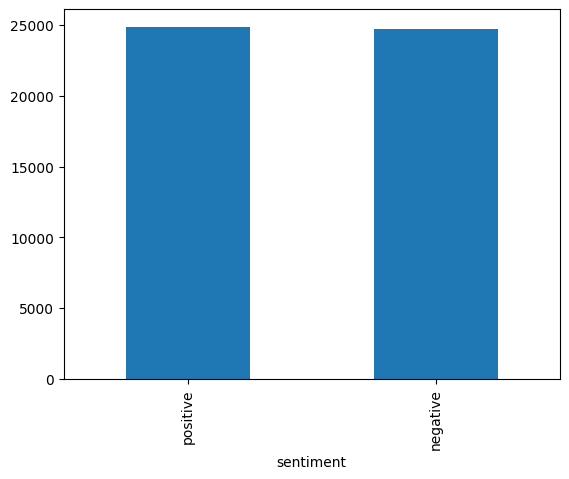

In [52]:
target_dist = df['sentiment'].value_counts()
target_dist.plot(kind = 'bar')

Balancing isn't needed. <br>

Now, for each row, we're gonna preprocess the text by removing stopwords, punctuation, and converting the text to lowercase. We're also gonna tokenize the text and lemmatize it. We're gonna use the WordNetLemmatizer from the nltk library.
    

In [53]:
#Taking an example text for analyzing the preprocessing method to use
text = df.iloc[1, 0]

text

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [54]:
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

#For removing the HTML markdown tags (such as those present in text above)
def remove_html_tags(text):
    pattern = re.compile("<.*?>")
    return pattern.sub(r"", text)

mkd_removed_text = remove_html_tags(text)
mkd_removed_text

'A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well done.'

In [55]:
#Now, converting into lowercase
mkd_removed_text = mkd_removed_text.lower()
mkd_removed_text

'a wonderful little production. the filming technique is very unassuming- very old-time-bbc fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. the actors are extremely well chosen- michael sheen not only "has got all the polari" but he has all the voices down pat too! you can truly see the seamless editing guided by the references to williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. a masterful production about one of the great master\'s of comedy and his life. the realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. it plays on our knowledge and our senses, particularly with the scenes concerning orton and halliwell and the sets (particularly of their flat with halliwell\'s murals decorating every surface) are terribly well done.'

In [56]:
#For removing any type of links present in the text

#For removing URL links
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)


- https?://: Matches http:// or https://. The s? part makes the s optional, so it matches both http and https.
- \S+: Matches one or more non-whitespace characters, effectively capturing the entire URL.
- |: Acts as an OR operator, meaning the pattern will match either the left side (https?://\S+) or the right side (www\.\S+).
- www\.\S+: Matches URLs starting with www. followed by one or more non-whitespace characters.


In [57]:
#Now, removing the punctuation marks
punctuation_marks = string.punctuation

def remove_punctuations(text):
    for punctuation in punctuation_marks:
        text = text.replace(punctuation, "")
    return text

In [58]:
mkd_url_removed =  remove_url(mkd_removed_text)
mkd_punct_removed = remove_punctuations(mkd_url_removed)

print(mkd_punct_removed)

a wonderful little production the filming technique is very unassuming very oldtimebbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done


In [59]:
#Now, finally removing the stopwords
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

mkd_stopwords_removed = remove_stopwords(mkd_punct_removed)
print(mkd_stopwords_removed)

wonderful little production filming technique unassuming oldtimebbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great masters comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwells murals decorating every surface terribly well done


In [60]:
#Now that we've decided how to pre-process each line, we will do it for all the reviews present
def preprocess_text(text):
    text = remove_html_tags(text)
    text = text.lower()
    text = remove_url(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    return text

In [61]:
no_rows = df.shape[0]
for i in range(no_rows):
    df.iloc[i, 0] = preprocess_text(df.iloc[i, 0])

In [62]:
df

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,im going disagree previous comment side maltin...,negative


Data has been successfully pre-processed. Now, preparing the data for training the model.

Since we're tackling with text-based data, we will have to use the bag-of-words model, utilizing techniques such as TF vectorization
    

In [63]:
X = df['review']
Y = df['sentiment']

le = LabelEncoder()
Y_enc = le.fit_transform(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y_enc, test_size = 0.25, random_state = 42)

vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

# Save the fitted CountVectorizer for future use
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

Now, our data is ready to be put into the models

**Preprocessing done by Fahad Salman Amim (26/7/2024)**

***
***

## **Model Development**

### **Using ML models:**

#### **Initializing Naive Bayes models**

In [18]:
mn = MultinomialNB()
bn = BernoulliNB()

##### MultinomialNB


In [19]:
# MultinomialNB
mn.fit(x_train, y_train)
mn_pred_test = mn.predict(x_test)
mn_pred_train = mn.predict(x_train)

##### BernoulliNB


In [20]:
# BernoulliNB
bn.fit(x_train, y_train)
bn_pred_test = bn.predict(x_test)
bn_pred_train = bn.predict(x_train)



---



---



#### **Logistic Regression**

In [21]:
# Initializing Logistic Regression model
lr = LogisticRegression()

# Training the model
lr.fit(x_train, y_train)

# Making predictions on the test set
lr_pred_test = lr.predict(x_test)

# Making predictions on the train set
lr_pred_train = lr.predict(x_train)

#### **Random Forest**

In [22]:
# Initializing Logistic Regression model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rfc.fit(x_train, y_train)

# Making predictions on the test set
rfc_pred_test = rfc.predict(x_test)

# Making predictions on the train set
rfc_pred_train = rfc.predict(x_train)

**ML NB models done by : Malaika Ahmed**

#### **Using Deep Learning Model:**

Applying a neural network to text data


In [66]:
# Seperating target and features
X1 = df['review']
y1 = df['sentiment']

In [67]:
# Splitting the data into train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [68]:
# Determine max_words

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X1_train)
vocab_size = len(tokenizer.word_index)
# Limit vocabulary size based on frequency (e.g., 5000 most frequent words)
max_words = min(5000, vocab_size)

# Reinitialize Tokenizer with limited vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X1_train)

# Determine max_length

x1_train_sequences = tokenizer.texts_to_sequences(X1_train)
# max_length = max(len(seq) for seq in x1_train_sequences)  # Determine max_length dynamically
max_length = int(np.percentile([len(seq) for seq in x1_train_sequences], 80))  # Determine max sequence length (e.g., 95th percentile)


print(f"Number of unique words (vocab_size): {max_words}")
print(f"Max sequence length (max_length): {max_length}")

Number of unique words (vocab_size): 5000
Max sequence length (max_length): 131


In [72]:
# Preprocessing steps:

# # Defining max_words & max_length for tokenization and padding:
max_words = 5000  # Maximum number of words to keep based on frequency
max_length = 100  # Maximum length of sequences (words) or Vocabsize

# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X1_train)

#Saving the tokenizer
tokenizer_json = tokenizer.to_json()

# Save the tokenizer JSON string to a file
with open('tokenizer.json', 'w') as file:
    json.dump(tokenizer_json, file)
    

x1_train_sequences = tokenizer.texts_to_sequences(X1_train)
x1_test_sequences = tokenizer.texts_to_sequences(X1_test)

# Padding
x1_train_padded = pad_sequences(x1_train_sequences, maxlen=max_length, padding='post', truncating='post')
x1_test_padded = pad_sequences(x1_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Converting labels to numerical format
label_encoder = LabelEncoder()
y1_train = label_encoder.fit_transform(y1_train)
y1_test = label_encoder.transform(y1_test)

# Printing sizes and samples to verify
print("Sizes and Samples Verification:")
print("--------------------------------")
print(f"Size of x1_train_padded: {x1_train_padded.shape}")
print(f"Size of y1_train: {y1_train.shape}")
print(f"Size of x1_test_padded: {x1_test_padded.shape}")
print(f"Size of y1_test: {y1_test.shape}")
print("--------------------------------")
print("Sample Data:")
print("--------------------------------")
print("Sample x1_train_padded:")
print(x1_train_padded[:4])  # Print first 4 samples
print("--------------------------------")
print("Sample y1_train:")
print(y1_train[:4])  # Print first 4 samples

Sizes and Samples Verification:
--------------------------------
Size of x1_train_padded: (39665, 100)
Size of y1_train: (39665,)
Size of x1_test_padded: (9917, 100)
Size of y1_test: (9917,)
--------------------------------
Sample Data:
--------------------------------
Sample x1_train_padded:
[[   9  303    1   72   60    4  455  233  202  221 4418  493    1   16
     4 1194 1453  306  754  189  297   20    6   40  222   47 1269  249
   117 2610    1    4  115   65 1901  173   65 1782  924   18  574  252
    26 1137   72   79   65  924    1  259  189  259  108    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 713   29    1 3008    1   43   85  705  381  148    1   57  567  564
   456   54  137  294 2946  605    1   68  265 1523   74    8  805  472
     1    7  106  907   46   85   64  210   1

In [27]:
# Building an LSTM model

model_LSTM = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')  # for binary classification
])

model_LSTM.build(input_shape=(None, max_length))

# Compiling the model
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Printing model summary
print("LSTM Model Summary:")
print("-------------------")
model_LSTM.summary()

LSTM Model Summary:
-------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,113 (1.47 MB)

 Trainable params: 386,113 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Training the model
history = model_LSTM.fit(x1_train_padded, y1_train, epochs=10, batch_size=32, validation_data=(x1_test_padded, y1_test))

Epoch 1/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 76s 58ms/step - accuracy: 0.5546 - loss: 0.6781 - val_accuracy: 0.5580 - val_loss: 0.6836
Epoch 2/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 76s 62ms/step - accuracy: 0.6773 - loss: 0.6018 - val_accuracy: 0.8353 - val_loss: 0.4022
Epoch 3/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.8652 - loss: 0.3429 - val_accuracy: 0.8636 - val_loss: 0.3244
Epoch 4/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 75s 61ms/step - accuracy: 0.8954 - loss: 0.2679 - val_accuracy: 0.8687 - val_loss: 0.3154
Epoch 5/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 75s 61ms/step - accuracy: 0.9120 - loss: 0.2346 - val_accuracy: 0.8714 - val_loss: 0.3141
Epoch 6/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.9336 - loss: 0.1908 - val_accuracy: 0.8627 - val_loss: 0.3266
Epoch 7/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.9521 - loss: 0.1410 - val_accuracy: 0.8590 - val_loss: 0.3902
Epoch 8/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.9652 -

In [29]:
# Making predictions
lstm_pred = model_LSTM.predict(x1_test_padded)
lstm_pred = lstm_pred.flatten()
predictions=pd.DataFrame({'y_test': y1_test, "predicted_y": lstm_pred})
predictions.head(5)

310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step


,y_test,predicted_y
0,0,0.001345
1,1,0.004321
2,0,0.001473
3,0,0.183853
4,1,0.992177


In [30]:
# Evaluating the model
LSTM_loss, LSTM_acc = model_LSTM.evaluate(x1_test_padded, y1_test)
print(f'Test Accuracy: {LSTM_acc*100:.2f}%')

310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8464 - loss: 0.5939
Test Accuracy: 85.08%


#### ***Calculating the accuracy score for all ML Models:***

In [31]:
#Logistic Regression Test Accuracy
lr_acc_test = accuracy_score(y_test, lr_pred_test)

#MultinomialNB Test Accuracy
mn_acc_test = accuracy_score(y_test, mn_pred_test)

#BernoulliNB Test Accuracy
bn_acc_test = accuracy_score(y_test, bn_pred_test)

#Random Forest Test Accuracy
rfc_acc_test = accuracy_score(y_test, rfc_pred_test)

#Logistic Regression Train Accuracy
lr_acc_train = accuracy_score(y_train, lr_pred_train)

#MultinomialNB Train Accuracy
mn_acc_train = accuracy_score(y_train, mn_pred_train)

#BernoulliNB Train Accuracy
bn_acc_train = accuracy_score(y_train, bn_pred_train)

#Random Forest Train Accuracy
rfc_acc_train = accuracy_score(y_train, rfc_pred_train)

# LSTM and RNN work fine in sequence data and also the NB

**Deep Learning model, Random Forest & Logistic Regression implemented by : Moneka**




---



## **Model Evaluation**

In [32]:
# Creating a DataFrame for accuracy table of all models
acc_table = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest","M_NaiveBayes","B_NaiveBayes", "LSTM"],
    "Accuracy": [lr_acc_test*100, rfc_acc_test*100, mn_acc_test*100, bn_acc_test*100, LSTM_acc*100]
})

# best model based on accuracy
best_model = acc_table.loc[acc_table['Accuracy'].idxmax()]

print("Accuracy Table:")
print(acc_table)

print(f"\nBest Model: {best_model['Model']} with Accuracy: {best_model['Accuracy']}")

Accuracy Table:
                 Model   Accuracy
0  Logistic Regression  88.230074
1        Random Forest  85.342046
2         M_NaiveBayes  85.640529
3         B_NaiveBayes  85.567925
4                 LSTM  85.076129

Best Model: Logistic Regression with Accuracy: 88.23007421748952


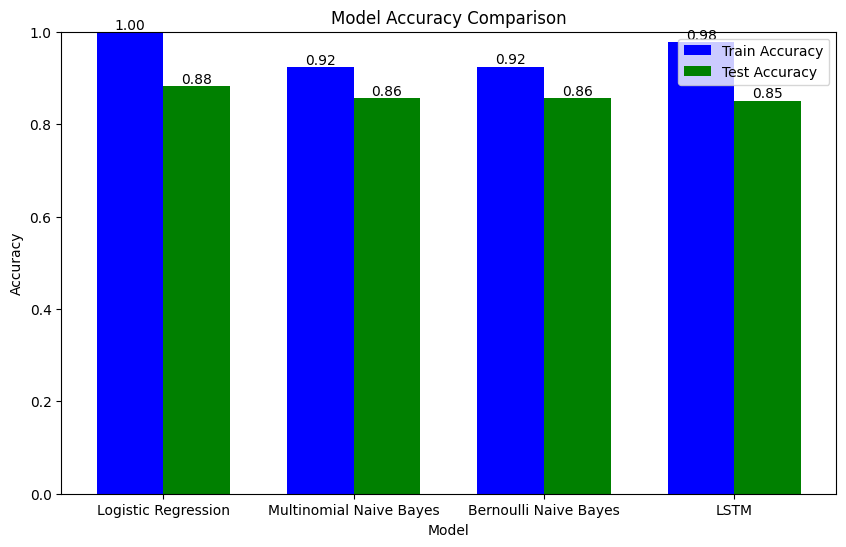

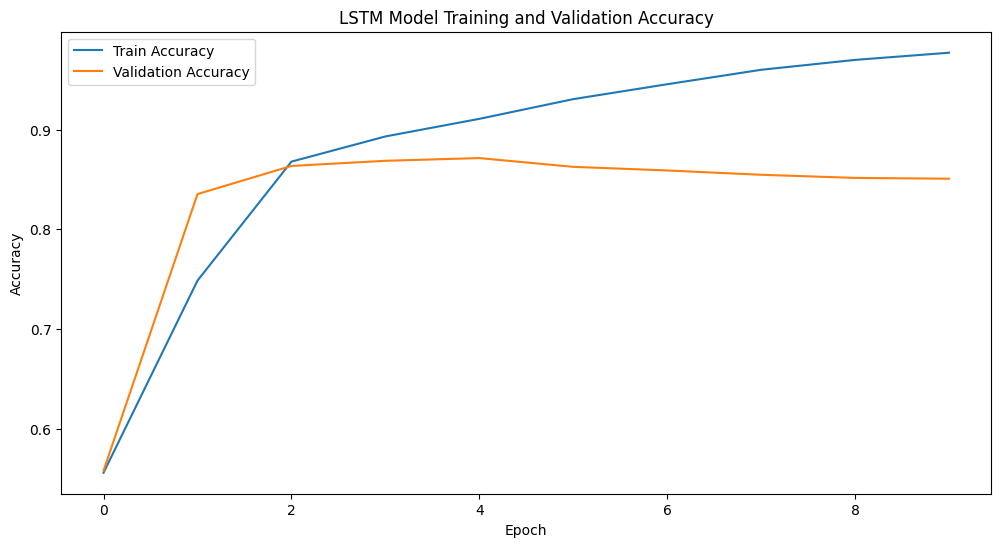

In [33]:

lr_train_acc = lr.score(x_train, y_train)
lr_test_acc = lr.score(x_test, y_test)

mn_train_acc = mn.score(x_train, y_train)
mn_test_acc = mn.score(x_test, y_test)

bn_train_acc = bn.score(x_train, y_train)
bn_test_acc = bn.score(x_test, y_test)

LSTM_train_acc = history.history['accuracy'][-1]
LSTM_test_acc = history.history['val_accuracy'][-1]

# Creating a DataFrame for accuracy table of all models
acc_table = pd.DataFrame({
    "Model": ["Logistic Regression", "Multinomial Naive Bayes", "Bernoulli Naive Bayes", "LSTM"],
    "Train Accuracy": [lr_train_acc, mn_train_acc, bn_train_acc, LSTM_train_acc],
    "Test Accuracy": [lr_test_acc, mn_test_acc, bn_test_acc, LSTM_test_acc]
})
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(acc_table['Model']))

# Plotting training accuracy
plt.bar(index, acc_table['Train Accuracy'], bar_width, label='Train Accuracy', color='blue')

# Plotting test accuracy
plt.bar(index + bar_width, acc_table['Test Accuracy'], bar_width, label='Test Accuracy', color='green')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(index + bar_width / 2, acc_table['Model'])
plt.ylim(0, 1)
plt.legend()
for i in range(len(acc_table)):
    plt.text(i, acc_table['Train Accuracy'][i], f"{acc_table['Train Accuracy'][i]:.2f}", ha='center', va='bottom')
    plt.text(i + bar_width, acc_table['Test Accuracy'][i], f"{acc_table['Test Accuracy'][i]:.2f}", ha='center', va='bottom')

plt.show()
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Model Training and Validation Accuracy')
plt.legend()
plt.show()


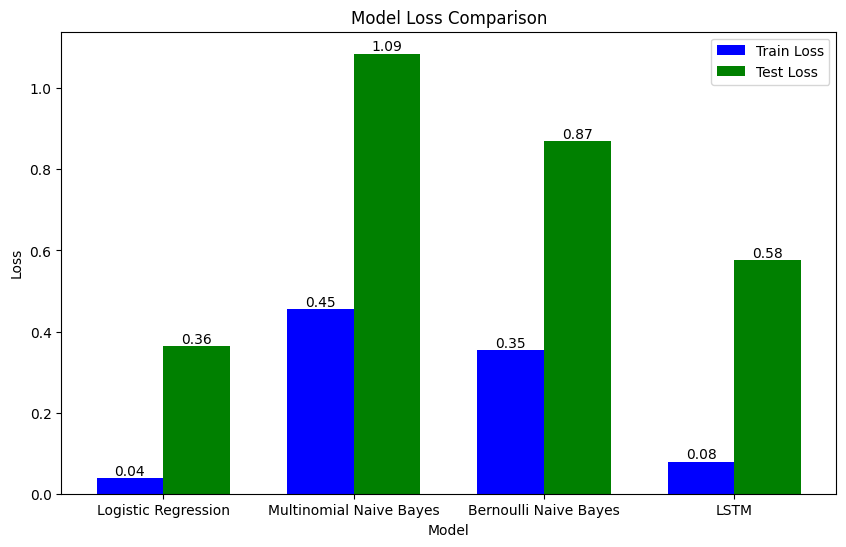

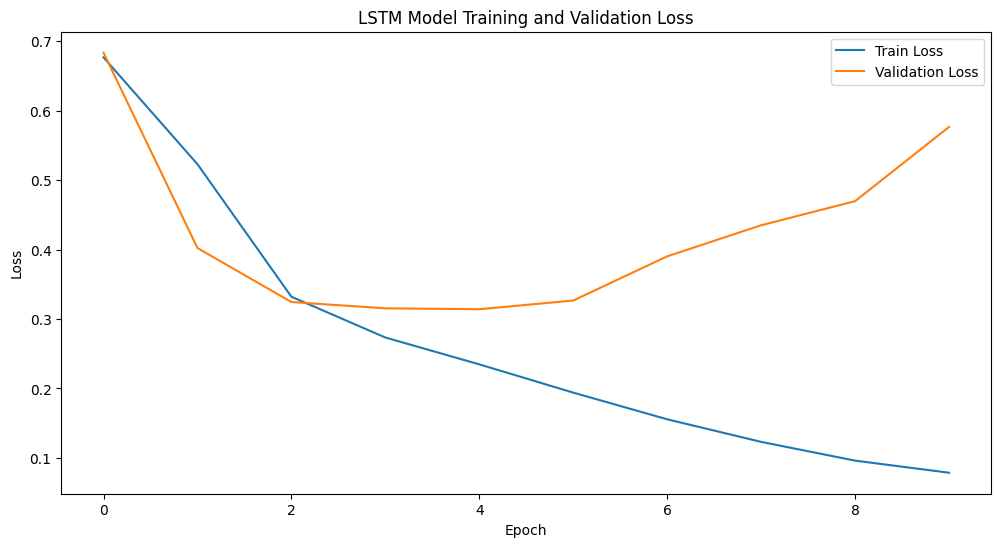

In [34]:

lr_train_loss = log_loss(y_train, lr.predict_proba(x_train))
lr_test_loss = log_loss(y_test, lr.predict_proba(x_test))

mn_train_loss = log_loss(y_train, mn.predict_proba(x_train))
mn_test_loss = log_loss(y_test, mn.predict_proba(x_test))

bn_train_loss = log_loss(y_train, bn.predict_proba(x_train))
bn_test_loss = log_loss(y_test, bn.predict_proba(x_test))

LSTM_train_loss = history.history['loss'][-1]  # Last epoch training loss
LSTM_test_loss = history.history['val_loss'][-1]  # Last epoch validation loss


acc_loss_table = pd.DataFrame({
    "Model": ["Logistic Regression", "Multinomial Naive Bayes", "Bernoulli Naive Bayes", "LSTM"],
    "Train Loss": [lr_train_loss, mn_train_loss, bn_train_loss, LSTM_train_loss],
    "Test Loss": [lr_test_loss, mn_test_loss, bn_test_loss, LSTM_test_loss]
})

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(acc_loss_table['Model']))
plt.bar(index, acc_loss_table['Train Loss'], bar_width, label='Train Loss', color='blue')
plt.bar(index + bar_width, acc_loss_table['Test Loss'], bar_width, label='Test Loss', color='green')

plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')
plt.xticks(index + bar_width / 2, acc_loss_table['Model'])
plt.legend()

for i in range(len(acc_loss_table)):
    plt.text(i, acc_loss_table['Train Loss'][i], f"{acc_loss_table['Train Loss'][i]:.2f}", ha='center', va='bottom')
    plt.text(i + bar_width, acc_loss_table['Test Loss'][i], f"{acc_loss_table['Test Loss'][i]:.2f}", ha='center', va='bottom')

plt.show()
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.legend()
plt.show()


In [36]:

# Predictions
lr_pred = lr.predict(x_test)
mn_pred = mn.predict(x_test)
bn_pred = bn.predict(x_test)
lstm_pred = model_LSTM.predict(x1_test_padded)
lstm_pred = np.where(lstm_pred > 0.5, 1, 0)  # Convert probabilities to binary predictions

# Evaluation
lr_accuracy = accuracy_score(y_test, lr_pred)
mn_accuracy = accuracy_score(y_test, mn_pred)
bn_accuracy = accuracy_score(y_test, bn_pred)
lstm_accuracy = accuracy_score(y1_test, lstm_pred)

# Confusion matrices
lr_cm = confusion_matrix(y_test, lr_pred)
mn_cm = confusion_matrix(y_test, mn_pred)
bn_cm = confusion_matrix(y_test, bn_pred)
lstm_cm = confusion_matrix(y1_test, lstm_pred)

# Classification reports
lr_report = classification_report(y_test, lr_pred)
mn_report = classification_report(y_test, mn_pred)
bn_report = classification_report(y_test, bn_pred)
lstm_report = classification_report(y1_test, lstm_pred)

# Displaying the classification reports
print("Logistic Regression Classification Report:")
print(lr_report)
print("\nMultinomial Naive Bayes Classification Report:")
print(mn_report)
print("\nBernoulli Naive Bayes Classification Report:")
print(bn_report)
print("\nLSTM Classification Report:")
print(lstm_report)

# Creating a DataFrame for accuracy comparison
acc_table = pd.DataFrame({
    "Model": ["Logistic Regression", "Multinomial Naive Bayes", "Bernoulli Naive Bayes", "LSTM"],
    "Accuracy": [lr_accuracy, mn_accuracy, bn_accuracy, lstm_accuracy]
})

# Creating a DataFrame for loss comparison
loss_table = pd.DataFrame({
    "Model": ["Logistic Regression", "Multinomial Naive Bayes", "Bernoulli Naive Bayes", "LSTM"],
    "Loss": [log_loss(y_test, lr.predict_proba(x_test)),
             log_loss(y_test, mn.predict_proba(x_test)),
             log_loss(y_test, bn.predict_proba(x_test)),
             LSTM_test_loss]
})



310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      6168
           1       0.88      0.89      0.88      6228

    accuracy                           0.88     12396
   macro avg       0.88      0.88      0.88     12396
weighted avg       0.88      0.88      0.88     12396


Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      6168
           1       0.87      0.84      0.85      6228

    accuracy                           0.86     12396
   macro avg       0.86      0.86      0.86     12396
weighted avg       0.86      0.86      0.86     12396


Bernoulli Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      6168
           1       0.87      0.83      0.85      6228

   

**Evaluation Metrics done by : Hassan**

In [48]:
#Saving all the models for future use
model_LSTM.save('LSTM_model.keras')  #The LSTM model

joblib.dump(lr, "lr_model.pkl")  #Logistic Regression Model
joblib.dump(mn, "mn_model.pkl")  #Multinomial Naive Bayes Model
joblib.dump(bn, "bn_model.pkl")  #Bernoulli Naive Bayes Model
joblib.dump(rfc, "rfc_model.pkl")  #Random Forest Model
 

In [44]:
#Now checking the ML model on user's input
inp = "I love this movie!"
inp = preprocess_text(inp)
inp = vectorizer.transform([inp])

user_pred_lr = lr.predict(inp)
print(user_pred_lr.dtype)
print(user_pred_lr[0])

int32
1


In [47]:
#Now checking the DL model on user's input
inp = "I love this movie!"
inp = preprocess_text(inp)
inp = tokenizer.texts_to_sequences([inp])
inp = pad_sequences(inp, maxlen=max_length, padding='post', truncating='post')

user_pred_lstm = model_LSTM.predict(inp)
print(user_pred_lstm.dtype)
print(user_pred_lstm[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
float32
0.8731277


### **GUI Implementation**

#### Run the code below if the earlier preprocessing cells were not run & you want to execute directly.
However, to run directly, please ensure:
 - models are saved onto disk for easy loading
 - the cell block for importing libraries has been run

In [2]:
def remove_html_tags(text):
    pattern = re.compile("<.*?>")
    return pattern.sub(r"", text)

def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

def remove_punctuations(text):
    punctuation_marks = string.punctuation
    for punctuation in punctuation_marks:
        text = text.replace(punctuation, "")
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

def preprocess_text(text):
    text = remove_html_tags(text)
    text = text.lower()
    text = remove_url(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    return text

In [3]:
with open('tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

vectorizer = joblib.load("vectorizer.pkl")

def preprocess_for_lstm(text):
    max_words = 5000  # Maximum number of words to keep based on frequency
    max_length = 100  # Maximum length of sequences (words) or Vocabsize
    text = preprocess_text(text)
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=max_length, padding='post', truncating='post')
    return text  #Text will be ready to be put into the LSTM

def preprocess_for_ml(text):
    text = preprocess_text(text)
    text = vectorizer.transform([text])
    return text #Text will be ready to be put into the ML models

In [4]:
#Loading the models
lstm_model = load_model('LSTM_model.keras')
rfc_model = joblib.load("rfc_model.pkl")
lr_model = joblib.load("lr_model.pkl")
mn_model = joblib.load("mn_model.pkl")
bn_model = joblib.load("bn_model.pkl")

In [75]:
inp = "I hate this movie!"
inp = preprocess_for_lstm(inp)
pred = lstm_model.predict(inp)
print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.14149615]]


In [65]:
inp = "I love this movie!"
n_inp = preprocess_for_ml(inp)
pred = lr_model.predict(n_inp)
print(pred[0])

1


#### Preparing the main GUI

In [5]:
# Main constructor
root = tk.Tk()
root.title("Sentiment Analyzer")
root.geometry("800x600")

models = {
    "Logistic Regression": lr_model,
    "Random Forest": rfc_model,
    "MultinomialNB": mn_model,
    "BernoulliNB": bn_model,
    "LSTM": lstm_model
}

# Label for user input
label = tk.Label(root, text="Enter the text to analyze:", font=('Arial', 18))
label.pack(pady=30)

# The text box for user input
TextBox = tk.Text(root, height=3, width=50, font=('Arial', 14))
TextBox.pack()

# Function to handle predictions
def action_predict():
    text = TextBox.get("1.0", tk.END).strip()
    if not text:
        tk.messagebox.showerror("Input Error", "Please enter some text to analyze.")
        return

    model_name = model_var.get()
    model = models[model_name]

    if model_name == "LSTM":
        text = preprocess_for_lstm(text)
        pred = model.predict(text)
        result = "Positive" if pred[0][0] >= 0.5 else "Negative"
        print(result)
    else:
        text = preprocess_for_ml(text)
        pred = model.predict(text)
        result = "Positive" if pred[0] == 1 else "Negative"
        print(result)
    
    result_label.config(text=f"Prediction: {result}")

# Drop-down menu for model selection
model_var = tk.StringVar(value="Logistic Regression")
model_dropdown = ttk.Combobox(root, textvariable=model_var, values=list(models.keys()), state="readonly", font=('Arial', 14))
model_dropdown.pack(pady=20)

# Button to trigger prediction
predict_button = tk.Button(root, text="Predict", font=('Arial', 14), command=action_predict)
predict_button.pack(pady=20)

# Label to display prediction
result_label = tk.Label(root, text="", font=('Arial', 14))
result_label.pack(pady=20)

root.mainloop()

Negative
Negative


**GUI done by : Fahad Salman Amim**